Brick CNot with random single Qubit gates

In [259]:

# import numpy as np
from qiskit import QuantumCircuit, transpile,Aer,execute
# from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator,qasm_simulator
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info import DensityMatrix, partial_trace,random_statevector
import random
import numpy as np
import math
import matplotlib.pyplot as plt

Brick cnot clifford

In [348]:
def initialize_zero(q,n):
    for i in range(n):
        q.initialize([1,0],i)
    return(q)
def initialize_R_product_state(q,n):
    for i in range(n):
        q.initialize(random_statevector(2).data,i)
    return(q)
def random_clifford(n,qc):
    qubits_list=list(range(n))
    for i in range(500):
        choice=random.choices(['s','h','cnot'])[0]
        qbit=random.choices(qubits_list)[0]
        if choice=='s':
            qc.s(qbit)
        elif choice=='h':
            qc.h(qbit)
        elif choice=='cnot':
            c=qubits_list.copy()
            c.remove(qbit)
            control_bit=random.choices(c)[0]
            qc.cnot(control_bit,qbit)
    return qc
def Block_Cnot_clifford(n,qc,first):
    if(first==True):
        depth=500
    else:
        depth=math.log(n,2)
    layer=0

    while(depth>layer):
        ##layer of even random s and t gate
        for i in range(n):
            choice=random.choices(['s','h'])[0]
            if(choice=='s'):
                qc.s(i)
            elif(choice=='h'):
                qc.h(i)
        layer+=1
        ##layer of even cnot gate 
        for i in range(0,n-1,2):
            qc.cnot(i,i+1)
        layer+=1
        
        ##layer of odd random s and t gate again 
        for i in range(1,n-1,1):
            choice=random.choices(['s','h'])[0]
            if(choice=='s'):
                qc.s(i)
            elif(choice=='h'):
                qc.h(i)
        layer+=1
        
        ##layer of odd cnot    
        for i in range(1,n-2,2):
            qc.cnot(i,i+1)
        layer+=1
    return qc

In [352]:
n=10
qc=QuantumCircuit(n)
##initialization
qc=initialize_R_product_state(qc,n)
# qc=initialize_zero(qc,n)
qc=random_clifford(n,qc)
# layer of T gate
# for i in range(n):
#     qc.t(i)
# qc=random_clifford(n,qc)
qc.draw()

┌──────────────────────────────────────────────┐                     »
q_0: ──┤ Initialize(0.85696+0.13475j,0.3476-0.35586j) ├─────────────────────»
       ├──────────────────────────────────────────────┤ ┌───┐┌───┐          »
q_1: ──┤ Initialize(0.90308+0.22811j,0.32524+0.1632j) ├─┤ S ├┤ S ├──────────»
     ┌─┴──────────────────────────────────────────────┴┐├───┤├───┤┌───┐     »
q_2: ┤ Initialize(-0.22335+0.28519j,-0.85938-0.36091j) ├┤ S ├┤ S ├┤ S ├─────»
     └┬────────────────────────────────────────────────┤├───┤└───┘└───┘     »
q_3: ─┤ Initialize(0.66339+0.22439j,-0.61964+0.35442j) ├┤ S ├───────────────»
      ├────────────────────────────────────────────────┤├───┤┌───┐┌───┐┌───┐»
q_4: ─┤ Initialize(0.72318+0.22619j,-0.40325-0.51307j) ├┤ S ├┤ H ├┤ S ├┤ S ├»
      ├───────────────────────────────────────────────┬┘├───┤└───┘└───┘├───┤»
q_5: ─┤ Initialize(0.25997+0.76799j,0.56947+0.13531j) ├─┤ H ├───────■──┤ H ├»
      ├───────────────────────────────────────────────┴┐└───┘┌───┐  │  ├───┤»
q_6: ─┤ Initialize(0.81274+0.11003j,0.56854+0.064079j) ├──■──┤ H ├──┼──┤ H ├»
      ├────────────────────────────────────────────────┤  │  └───┘┌─┴─┐└───┘»
q_7: ─┤ Initialize(0.86217-0.066994j,0.10842-0.49032j) ├──┼───────┤ X ├─────»
      ├───────────────────────────────────────────────┬┘┌─┴─┐┌───┐├───┤┌───┐»
q_8: ─┤ Initialize(-0.3701+0.61027j,-0.63884+0.2872j) ├─┤ X ├┤ H ├┤ S ├┤ S ├»
      └┬──────────────────────────────────────────────┤ ├───┤├───┤├───┤└───┘»
q_9: ──┤ Initialize(0.75729+0.6351j,0.04281+0.14604j) ├─┤ H ├┤ S ├┤ S ├─────»
       └──────────────────────────────────────────────┘ └───┘└───┘└───┘     »
«                         ┌───┐                              ┌───┐     ┌───┐»
«q_0: ─────────────────■──┤ H ├──────────────────────────────┤ X ├─────┤ X ├»
«          ┌───┐┌───┐  │  ├───┤               ┌───┐     ┌───┐└─┬─┘     └─┬─┘»
«q_1: ─────┤ X ├┤ H ├──┼──┤ S ├───────■───────┤ X ├─────┤ X ├──■─────────┼──»
«     ┌───┐└─┬─┘├───┤  │  └───┘┌───┐  │  ┌───┐└─┬─┘┌───┐└─┬─┘┌───┐┌───┐  │  »
«q_2: ┤ X ├──┼──┤ H ├──┼────■──┤ H ├──┼──┤ H ├──┼──┤ H ├──┼──┤ S ├┤ S ├──┼──»
«     └─┬─┘  │  └───┘  │    │  └───┘┌─┴─┐├───┤  │  └───┘  │  └───┘├───┤  │  »
«q_3: ──┼────┼─────────┼────┼────■──┤ X ├┤ X ├──┼─────────┼────■──┤ H ├──┼──»
«       │    │         │    │    │  └───┘└─┬─┘  │         │    │  └───┘  │  »
«q_4: ──┼────┼─────────┼────┼────┼─────────┼────┼─────────┼────┼─────────■──»
«       │    │  ┌───┐  │    │    │         │    │  ┌───┐  │    │            »
«q_5: ──┼────■──┤ S ├──┼────┼────┼─────────┼────■──┤ S ├──┼────┼────────────»
«       │  ┌───┐└───┘┌─┴─┐  │    │         │  ┌───┐├───┤  │  ┌─┴─┐┌───┐     »
«q_6: ──┼──┤ H ├─────┤ X ├──┼────┼─────────■──┤ S ├┤ H ├──┼──┤ X ├┤ S ├─────»
«       │  ├───┤┌───┐└───┘  │  ┌─┴─┐┌───┐┌───┐├───┤├───┤  │  └───┘└───┘     »
«q_7: ──■──┤ H ├┤ H ├───────┼──┤ X ├┤ H ├┤ S ├┤ S ├┤ H ├──┼─────────────────»
«          └───┘└───┘       │  └───┘└───┘└───┘└───┘└───┘  │       ┌───┐     »
«q_8: ──────────────────────┼─────────────────────────────■────■──┤ S ├─────»
«                         ┌─┴─┐┌───┐                         ┌─┴─┐├───┤     »
«q_9: ────────────────────┤ X ├┤ S ├─────────────────────────┤ X ├┤ S ├─────»
«                         └───┘└───┘                         └───┘└───┘     »
«     ┌───┐┌───┐                                        ┌───┐               »
«q_0: ┤ S ├┤ X ├────────────────────────────────────────┤ X ├───────────────»
«     └───┘└─┬─┘                              ┌───┐┌───┐└─┬─┘     ┌───┐┌───┐»
«q_1: ───────┼─────────────────────────────■──┤ X ├┤ H ├──┼───────┤ X ├┤ H ├»
«     ┌───┐  │                             │  └─┬─┘└───┘  │  ┌───┐└─┬─┘├───┤»
«q_2: ┤ H ├──┼─────────────────────────────┼────┼─────────┼──┤ X ├──┼──┤ H ├»
«     └───┘  │  ┌───┐     ┌───┐            │    │         │  └─┬─┘  │  └───┘»
«q_3: ──■────┼──┤ S ├──■──┤ H ├────────────┼────┼─────────┼────┼────■────■──»
«       │    │  └───┘┌─┴─┐├───┤┌───┐┌───┐  │    │  ┌───┐  │    │         │  »
«q_4: ──┼────┼───────┤ X ├┤ X

In [356]:
state= DensityMatrix.from_instruction(qc) ##get the state vector of the system
# print(state)
rho_a=partial_trace(state=state,qargs=list(range(int(n/2),n-1))) ##rho_a is the reduced density matrix for the first a subsystem A(as the paper has divided the whole system into A and B subsystem)
eigenvalues=np.linalg.eigvals(rho_a.data) ##entanglement spectrum is the set of the eigen values of the reduced density matrix
ES=sorted(eigenvalues,reverse=True)
print(ES)
ES_real=[i.real for i in ES ]
print(ES_real)
lambd=np.sqrt(ES_real)
# lambd=ES_real
print(lambd)

[(0.1410424633754373-5.164316122831708e-19j), (0.1393169231271141+1.8303146221331756e-18j), (0.09907144217886737+2.6102698856227876e-18j), (0.09571479318423122-7.557952627200732e-18j), (0.08877073840439186-1.0652295049265904e-17j), (0.08595223320336391-2.0124667278271363e-18j), (0.06791828345302416-3.095768594811835e-18j), (0.05582815302568229-1.2369635527671453e-17j), (0.04239302248248197+4.961589374041908e-18j), (0.04115294049857073-1.4354794720736468e-18j), (0.03144526442748253-1.943553995566561e-18j), (0.030288072005318942+8.321272856008041e-19j), (0.027719639427061394-1.7508631464608166e-18j), (0.023236803860486658-1.3021402653697214e-18j), (0.016115943028151895+2.5293480308522743e-18j), (0.01403328431830203-1.4530476685419808e-19j), (4.190156949295906e-17-1.1367819288999977e-17j), (3.5948608267362925e-17-1.8156849355672093e-18j), (3.224004435933865e-17+1.7842734932433723e-17j), (2.948367549782243e-17-1.4236663844816352e-17j), (2.6388039521757795e-17-1.796160501669466e-17j), (2.59

/var/folders/bn/bdb2r26j1455qswd6j9pcyjw0000gn/T/ipykernel_18364/432942279.py:9: RuntimeWarning: invalid value encountered in sqrt
  lambd=np.sqrt(ES_real)


In [357]:
print(lambd)
r_k_tilda=[]
for i in range(1,len(lambd)-1):
    del_k=lambd[i-1]-lambd[i]
    del_k_P1=lambd[i]-lambd[i+1]
    r_k_tilda.append(min(del_k,del_k_P1)/max(del_k,del_k_P1))
print(r_k_tilda)
r_mean=np.mean(r_k_tilda)
print(r_mean)

[3.75556205e-01 3.73251823e-01 3.14756163e-01 3.09378075e-01
 2.97944187e-01 2.93176113e-01 2.60611365e-01 2.36279819e-01
 2.05895659e-01 2.02861875e-01 1.77328126e-01 1.74034686e-01
 1.66492160e-01 1.52436229e-01 1.26948584e-01 1.18462164e-01
 6.47314217e-09 5.99571583e-09 5.67803173e-09 5.42988725e-09
 5.13692900e-09 5.09086303e-09 5.01507068e-09 4.81812494e-09
 4.47114875e-09 4.45325632e-09 4.23193188e-09 4.11755508e-09
 3.84428170e-09 3.83224622e-09 3.82598630e-09 3.49604716e-09
 3.32094567e-09 3.26817137e-09 2.77782510e-09 2.61967612e-09
 2.55876475e-09 2.22290582e-09 1.94904789e-09 1.51456617e-09
 1.16362105e-09 5.11703981e-10            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan]
[0.03939407970102173, 0

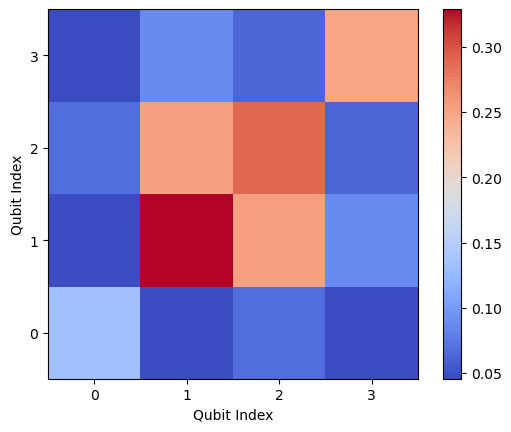

In [322]:
# matrix=rho_a.data
# fig,ax=plt.subplots()
# cax = ax.matshow(np.abs(matrix), cmap='coolwarm')  # 'coolwarm' is a color map; you can choose others like 'viridis', 'plasma', etc.
# fig.colorbar(cax)

# # Set the range for the ticks based on the size of the matrix
# ax.set_xticks(np.arange(matrix.shape[0]))
# ax.set_yticks(np.arange(matrix.shape[1]))
# # Move the ticks to the bottom and left side
# ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
# ax.tick_params(axis="y", left=True, right=False, labelleft=True, labelright=False)
# ax.invert_yaxis()
# # Label the ticks. Here we use numerical labels starting from 0
# ax.set_xticklabels(np.arange(matrix.shape[0]))
# ax.set_yticklabels(np.arange(matrix.shape[1]))

# ##labeling axis
# ax.set_xlabel('Qubit Index')
# ax.set_ylabel('Qubit Index')
# plt.show()

Statevector([-0.00631868+0.01740159j,  0.00577878-0.01467629j,
             -0.00679196+0.00110951j, ...,  0.02643365+0.00858696j,
             -0.02379794+0.00899301j,  0.00871156-0.00762131j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


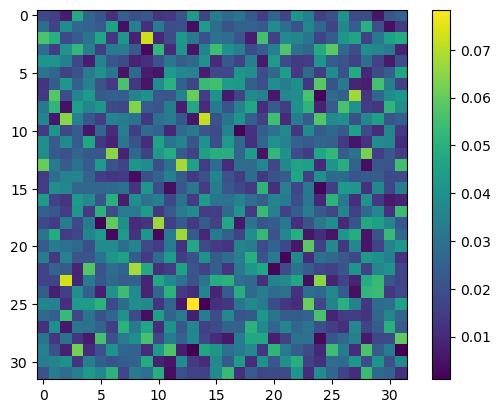

In [355]:

simulator = Aer.get_backend('statevector_simulator')
job = execute(qc, simulator)
result = job.result()
statevector = result.get_statevector(qc)
print(statevector)
# Create and display the color map
num_states =2** int(qc.num_qubits/2)
wavefunction_matrix = np.reshape(statevector, (num_states, num_states))
plt.imshow(np.abs(wavefunction_matrix), cmap='viridis', interpolation='nearest')
plt.colorbar()
# plt.show()

In [323]:
print(rho_a)

DensityMatrix([[ 0.13401311+1.73472348e-17j,  0.03803817-2.81749181e-02j,
                -0.06378957-2.44823733e-02j, -0.02848387-3.56571748e-02j],
               [ 0.03803817+2.81749181e-02j,  0.32884519-3.64291930e-17j,
                -0.06079179-2.44660967e-01j,  0.08724778-1.26973081e-02j],
               [-0.06378957+2.44823733e-02j, -0.06079179+2.44660967e-01j,
                 0.28832992-3.12250226e-17j,  0.02827877+5.65021014e-02j],
               [-0.02848387+3.56571748e-02j,  0.08724778+1.26973081e-02j,
                 0.02827877-5.65021014e-02j,  0.24881178+2.20309881e-16j]],
              dims=(2, 2))


## now lets start creating r^telda

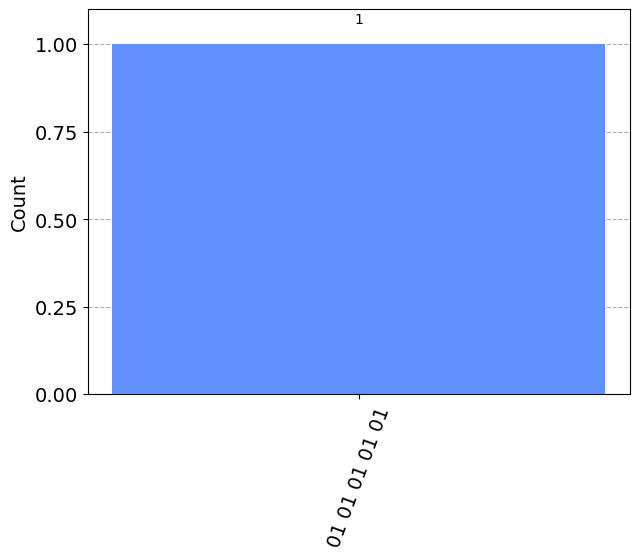

In [268]:

plot_histogram(result.get_counts(0))
# a=4
# list(range(int(a/2)))